In [91]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
from IPython.display import display, Markdown
np.random.seed(70) #for reproducibility

In [92]:
def inspect_data(A, b, true_coeffs):
    print("Shape of A: ", (A).shape)
    print("Shape of b: ", (b).shape)

    # Flatten the matrix A
    values_A = A.flatten()

    # Create a figure and a set of subplots
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))

    # Plot histogram for matrix A
    axs[0].hist(values_A, bins=50, color='blue', alpha=0.7)
    axs[0].set_title('Value Distribution of Matrix A')
    axs[0].set_xlabel('Value')
    axs[0].set_ylabel('Frequency')
    axs[0].grid(True)

    # Plot histogram for vector b
    axs[1].hist(b, bins=50, color='green', alpha=0.7)
    axs[1].set_title('Value Distribution of Vector b')
    axs[1].set_xlabel('Value')
    axs[1].set_ylabel('Frequency')
    axs[1].grid(True)

    # Plot histogram for vector true_coeffs
    axs[2].hist(true_coeffs, bins=50, color='red', alpha=0.7)
    axs[2].set_title('Value Distribution of true_coeffs')
    axs[2].set_xlabel('Value')
    axs[2].set_ylabel('Frequency')
    axs[2].grid(True)

    # Show the plots
    plt.tight_layout()  # Adjusts subplot params so that subplots fit into the figure area.
    plt.show()

In [93]:
def initialize_variables(Nx, Nb):
    # A in m rows, n columns
    # Nb = 1500 # Size of vector b (m)
    # Nx = 2000 # Size of vector x (n)

    # np.random.randn generates random numbers from a standard normal distribution (mean = 0, std = 1)
    A = np.random.randn(Nb, Nx)
    true_coeffs = np.random.randn(Nx)
    # A @ true_coeffs computes the dot product of each row of A with vector true_coeffs
    # which results in a new vector b of length Nb
    b = A @ true_coeffs + np.random.normal(0, 1, Nb) * 0.5
    x_init = np.zeros(Nx)
    z_init = np.zeros(Nx)

    # y represents the lagrange multiplier and dual variable
    y_init = np.zeros(Nx)
    
    return A, b, true_coeffs, x_init, z_init, y_init

In [94]:
def z_minimization_step(x, y, rho, lambd):
    tau = lambd / rho
    vector = x + y / rho
    # Apply soft-thresholding element-wise
    return np.sign(vector) * np.maximum(np.abs(vector) - tau, 0)

def ADMM_Lasso(A, b, x, z, y, rho, lambd, epsilon, max_iters):
    Nb = A.shape[0] # A has shape (Nb, Nx)
    Nx = A.shape[1]
    list_primal_res = []
    list_dual_res = []
    list_x = []
    list_z = []

    iters = np.arange(0, max_iters) # max number of iterations
    # (A.T * A + rho * I)^(-1)
    cached_inv = np.linalg.inv(np.matmul(A.T, A) + rho*np.identity(Nx)) # O(n^3)

    for k in iters:
        # primal variable updates
        x = np.matmul(cached_inv, np.matmul(A.T, b) + rho*z - y) # x-minimization step
        z_prev = z.copy() # Store the previous value of z for convergence checking
        z = z_minimization_step(x, y, rho, lambd) # z-minimization step

        # dual variable update
        y = y + rho * (x - z)

        # calculate residuals
        primal_res = np.linalg.norm(x - z, ord=2)
        dual_res = rho * np.linalg.norm(z - z_prev, ord=2)

        list_primal_res.append(primal_res)
        list_dual_res.append(dual_res)

        # Check for convergence
        if primal_res < epsilon and dual_res < epsilon:
            break
    list_x.append(x)
    return list_primal_res, list_dual_res, list_x, list_z

In [95]:
def plot_residuals(A_shape, list_primal_res, list_dual_res, rho, lambd, max_iters):
    plt.figure(figsize=(8,8))
    plt.plot(list_primal_res, label="Primal residual")
    plt.plot(list_dual_res, label="Dual residual")
    plt.yscale("log")
    plt.xlabel("Iterations")
    plt.ylabel("Residual Error")
    plt.title(f"Convergence Plot (Shape A: (rows={A_shape[0]}, cols={A_shape[1]})(rho={rho}, lambda={lambd})")
    plt.legend()
    plt.grid(which='both', axis='both')  # Enable grid for log scale
    plt.ylim(10**-15, 10**3)  # Limit the y-axis to this range.
    plt.xlim(0, max_iters)

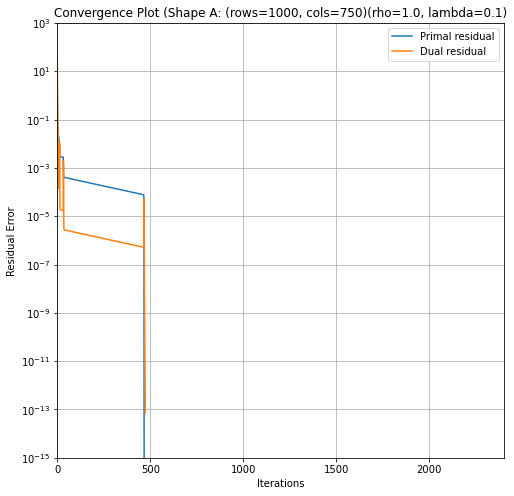

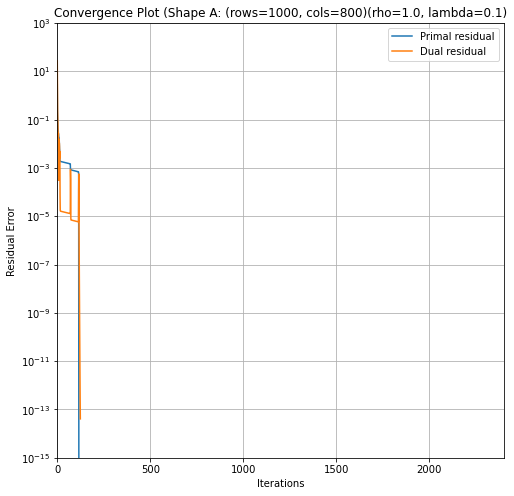

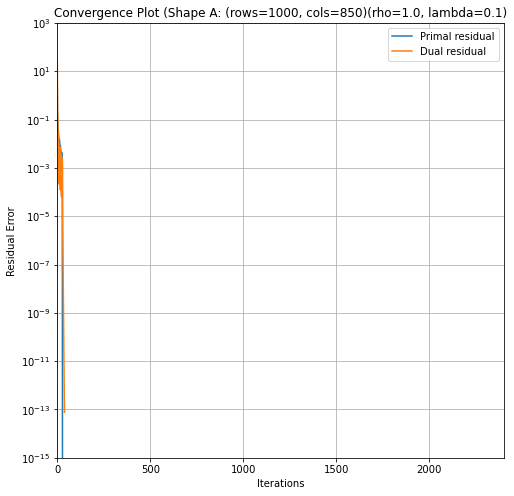

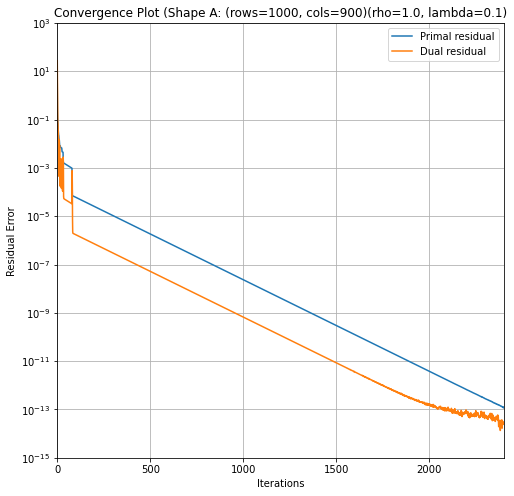

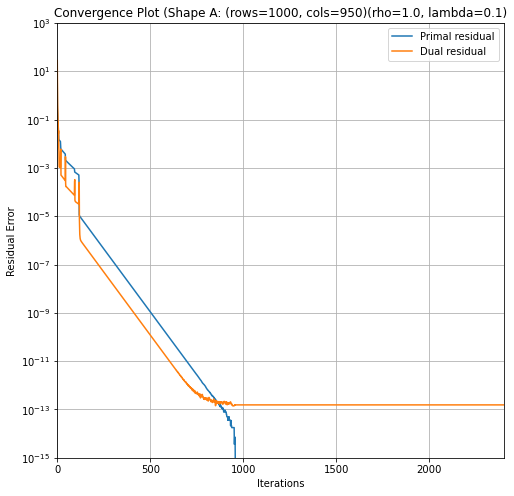

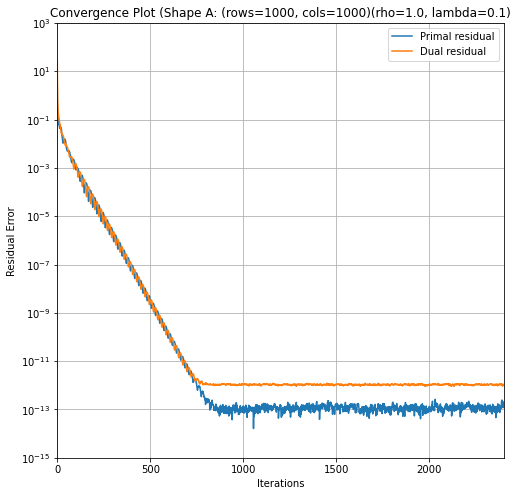

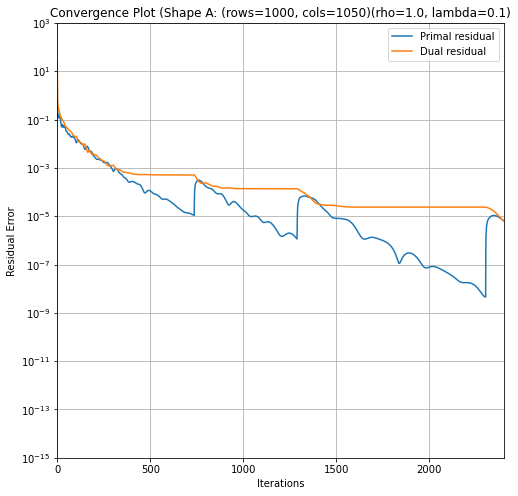

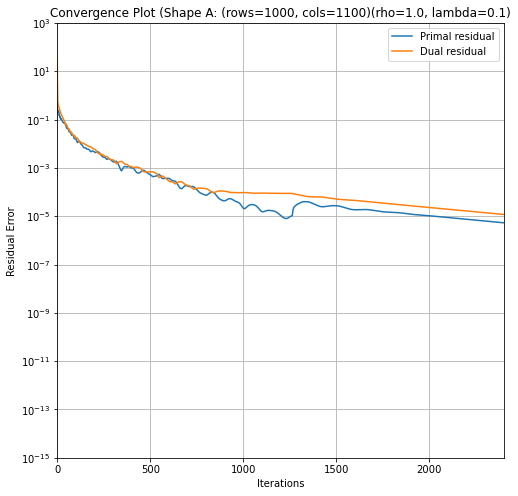

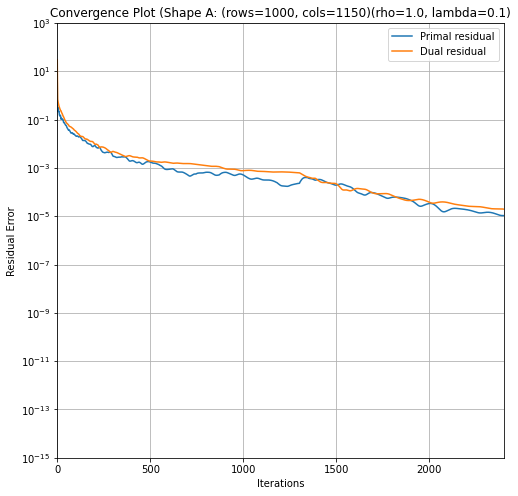

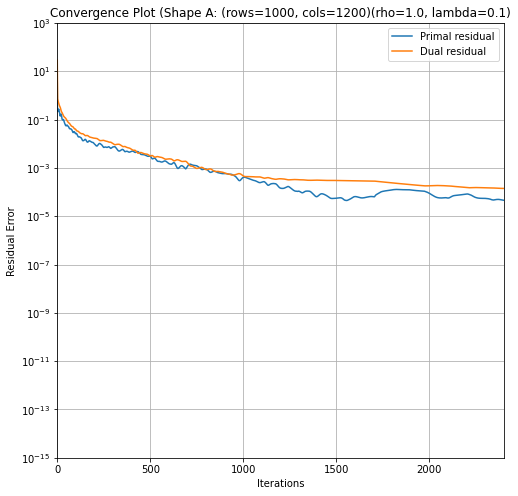

In [96]:
for i in range(10):
    # Test different dimensions of input matrix A.

    A_rows, A_cols = 1000, (750 + i * 50)
    A, b, true_coeffs, x_init, z_init, y_init = initialize_variables(Nx=A_cols, Nb=A_rows)
    # inspect_data(A, b, true_coeffs)
    
    lambd = 0.1
    rho = 1.0
    max_iters = 2400
    
    list_primal_res, list_dual_res, list_x, list_z = ADMM_Lasso(A, b, x_init, z_init, y_init, rho=rho, lambd=lambd, epsilon=1e-13, max_iters=max_iters)
    plot_residuals(A.shape, list_primal_res, list_dual_res, rho=rho, lambd=lambd, max_iters=max_iters)